<a href="https://colab.research.google.com/github/NirmalMendis/Phone-Price-Depreciation-Prediction/blob/main/PhonePriceDep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PHONE PRICE DEPRECIATION PREDICTION USING MACHINE LEARNING**

# **Importing Necessary Libraries**

In [50]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Common imports
import pandas as pd
import numpy as np
import os
import pickle

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#imports for neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

#Decision Tree
from sklearn.tree import DecisionTreeRegressor

#Random Forest
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Define Functions to be Used**

**Function 1**

Function to detect outliers using interquatile range and replace them with the median value of the column

In [52]:
def resolveOutliers(columnName):
  #Obtain quartiles

  q75 = data[columnName].quantile(0.75)
  q25 = data[columnName].quantile(0.25)
  intr_qr = q75-q25 #interqualite range

  #obtain an upperbound and lowerbound
  max = q75 + (1.5*intr_qr)
  min = q25 - (1.5*intr_qr)

  if(min<0):
    min = 0

  print("Upperbound",max)
  print("Lowerbound", min)

  median = data[columnName].quantile(0.5)
  print("Median ",columnName,":", median)
  data[columnName] = np.where(data[columnName] < min, median, data[columnName])
  data[columnName] = np.where(data[columnName] > max, median, data[columnName])

**Function 2**

Function to Evaluate Models using:

1.   Mean Absolute Error
2.   Mean Squared Error
3.   Root Mean Squared Error
4.   R Squared












In [53]:
#function to evaluate models
def print_evaluate(true, predicted, train=True):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    if train:
        print("========Training Result=======")
        print('MAE: ', mae)
        print('MSE: ', mse)
        print('RMSE: ', rmse)
        print('R2 Square: ', r2_square)
    elif not train:
        print("=========Testing Result=======")
        print('MAE: ', mae)
        print('MSE: ', mse)
        print('RMSE: ', rmse)
        print('R2 Square: ', r2_square)

**Function 3**

Function to print list of predicted prices along with the real price 

In [54]:
#Print predicted price and real price
def print_Predictions(y_predict):
  for x in range(10):
    print("Predicted price","   ","Real price")
    print(np.array(y_predict)[x],"    ",  np.array(y_test)[x])

**Function 4**

Function to print graphical representation of actual value and the predicated value 

In [55]:
#Graphical representation of the actual value and the predicated value

def graphical_Representation(y_test_prediction):
  width = 6
  height = 5
  plt.figure(figsize=(width, height))

  sns.distplot(y_test, hist=False, color="r", label="Actual Value")
  sns.distplot(y_test_prediction, hist=False, color='b', label="Fitted Values")

  #Actual color - red
  #predicted color - blue

  plt.title('Actual Vs Fitted Values For Price')
  plt.xlabel('Price in Sl Rupees')
  plt.ylabel('Proprtation of Phone')
  plt.legend() 
  plt.show()
  plt.close()

  plt.title('Actual Vs Fitted Values For Price')
  plt.scatter(y_test, y_test_prediction)
  plt.xlabel('Actual Price')
  plt.ylabel('Predicted Price')

**Function 5**

Function to cross validate models

In [56]:
#function to cross validate models
def crossValidate(model):  
    rfc_eval = cross_val_score(estimator = model, X = X, y = y, cv=KFold(10, shuffle=True, random_state=0))
    print('Average accuracy of 10 folds : ', rfc_eval.mean())

# **Data Preprocessing and Visualization**

In [57]:
#load dataset from drive
data = pd.read_excel(r'/content/drive/My Drive/test4.xlsm')
data.head(5)

,Brand,Model,Network(G),Release Month,Released Year,Weight,Build Back,Build Frame,SIM,Display type,Display Size (inches),ppi,Protection,OS,CPU Cores,CPU speed(Max),SD Card Slot,Internal Storage (GB),RAM (GB),Main Camera No.of Cameras,Main Camera MP(Max),Main Camera Video Quality(p),Main Camera FPS,Selfie Camera No.of Cameras,Selfie Camera(MP),Selfie Camera Video Quality(p),Selfie Camera FPS,Stereo Speakers,3.5mm jack,Bluetooth Version,NFC,Radio,Fingerprint,Face ID,Battery Capacity,Fast Charging,Wireless Charging,Reverse wireless charging,Date,Price
0,Apple,iPhone 6 16GB,4,9,2014,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,03/2017,67015.90797
1,Apple,iPhone 6 16GB,4,9,2014,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,04/2017,66537.91492
2,Apple,iPhone 6 16GB,4,9,2014,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,05/2017,66164.64992
3,Apple,iPhone 6 16GB,4,9,2014,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,06/2017,64271.06467
4,Apple,iPhone 6 16GB,4,9,2014,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,07/2017,61048.85175


Release Month and release Year are two columns. 
Here, we combine both columns to form one column of the format month/year.
This format is needed to calculate the number of months between release date and obtained price date.

In [58]:
#Create a new column in the format "releaseMonth/releaseYear"
data['release'] = data['Release Month'].map(str) + "/" + data['Released Year'].map(str)
target = data['Price'] 
#Drop the individual columns release month and release year( no longer needed)
#Drop "Model" attribute
data = data.drop(columns=['Release Month', 'Released Year','Model'])
data.head(5)

,Brand,Network(G),Weight,Build Back,Build Frame,SIM,Display type,Display Size (inches),ppi,Protection,OS,CPU Cores,CPU speed(Max),SD Card Slot,Internal Storage (GB),RAM (GB),Main Camera No.of Cameras,Main Camera MP(Max),Main Camera Video Quality(p),Main Camera FPS,Selfie Camera No.of Cameras,Selfie Camera(MP),Selfie Camera Video Quality(p),Selfie Camera FPS,Stereo Speakers,3.5mm jack,Bluetooth Version,NFC,Radio,Fingerprint,Face ID,Battery Capacity,Fast Charging,Wireless Charging,Reverse wireless charging,Date,Price,release
0,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,03/2017,67015.90797,9/2014
1,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,04/2017,66537.91492,9/2014
2,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,05/2017,66164.64992,9/2014
3,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,06/2017,64271.06467,9/2014
4,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,07/2017,61048.85175,9/2014


In [59]:
#Convert release date and price obtained date into Datetime format
data['release'] = pd.to_datetime(data['release'])
data['Date'] = pd.to_datetime(data['Date'])
data.head(5)

,Brand,Network(G),Weight,Build Back,Build Frame,SIM,Display type,Display Size (inches),ppi,Protection,OS,CPU Cores,CPU speed(Max),SD Card Slot,Internal Storage (GB),RAM (GB),Main Camera No.of Cameras,Main Camera MP(Max),Main Camera Video Quality(p),Main Camera FPS,Selfie Camera No.of Cameras,Selfie Camera(MP),Selfie Camera Video Quality(p),Selfie Camera FPS,Stereo Speakers,3.5mm jack,Bluetooth Version,NFC,Radio,Fingerprint,Face ID,Battery Capacity,Fast Charging,Wireless Charging,Reverse wireless charging,Date,Price,release
0,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,2017-03-01,67015.90797,2014-09-01
1,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,2017-04-01,66537.91492,2014-09-01
2,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,2017-05-01,66164.64992,2014-09-01
3,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,2017-06-01,64271.06467,2014-09-01
4,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,2017-07-01,61048.85175,2014-09-01


Calculate the number of months between release date and the price obtained date for each row

In [60]:
#Calculate the no of months since release
data['Months']= ((data.Date.dt.year - data.release.dt.year) * 12 + (data.Date.dt.month - data.release.dt.month))
#Drop release date and price obtained date columns(no longer needed)
data = data.drop(columns=['Date', 'release'])
data.head(5)

,Brand,Network(G),Weight,Build Back,Build Frame,SIM,Display type,Display Size (inches),ppi,Protection,OS,CPU Cores,CPU speed(Max),SD Card Slot,Internal Storage (GB),RAM (GB),Main Camera No.of Cameras,Main Camera MP(Max),Main Camera Video Quality(p),Main Camera FPS,Selfie Camera No.of Cameras,Selfie Camera(MP),Selfie Camera Video Quality(p),Selfie Camera FPS,Stereo Speakers,3.5mm jack,Bluetooth Version,NFC,Radio,Fingerprint,Face ID,Battery Capacity,Fast Charging,Wireless Charging,Reverse wireless charging,Price,Months
0,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,67015.90797,30
1,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,66537.91492,31
2,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,66164.64992,32
3,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,64271.06467,33
4,Apple,4,129.0,Aluminium,Aluminium,Single,IPS - LCD,4.7,326,Ion-strengthened glass,iOS,2,1.4,False,16,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,61048.85175,34


In [61]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5092 entries, 0 to 5091
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Brand                           5092 non-null   object 
 1   Network(G)                      5092 non-null   int64  
 2   Weight                          5092 non-null   float64
 3   Build Back                      4879 non-null   object 
 4   Build Frame                     4879 non-null   object 
 5   SIM                             5092 non-null   object 
 6   Display type                    5092 non-null   object 
 7   Display Size (inches)           5092 non-null   float64
 8   ppi                             5092 non-null   int64  
 9   Protection                      5072 non-null   object 
 10  OS                              5092 non-null   object 
 11  CPU Cores                       5092 non-null   int64  
 12  CPU speed(Max)                  50

We obtained a dataset of 5092 rows.
Now we clean this dataset by removing null values.

In [62]:
#Get column list with null values
data.columns[data.isnull().any()]

Index(['Build Back', 'Build Frame', 'Protection', 'Main Camera FPS',
       'Selfie Camera(MP)', 'Selfie Camera Video Quality(p)',
       'Selfie Camera FPS'],
      dtype='object')

In [63]:
#Drop rows null values
data = data.dropna();
data.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4192 entries, 0 to 5091
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Brand                           4192 non-null   object 
 1   Network(G)                      4192 non-null   int64  
 2   Weight                          4192 non-null   float64
 3   Build Back                      4192 non-null   object 
 4   Build Frame                     4192 non-null   object 
 5   SIM                             4192 non-null   object 
 6   Display type                    4192 non-null   object 
 7   Display Size (inches)           4192 non-null   float64
 8   ppi                             4192 non-null   int64  
 9   Protection                      4192 non-null   object 
 10  OS                              4192 non-null   object 
 11  CPU Cores                       4192 non-null   int64  
 12  CPU speed(Max)                  41

**Exploratory Data Analysis (EDA)**

In [64]:
#get columns with numerical values
numerical_cols = data.columns[data.dtypes==float].tolist() + data.columns[data.dtypes==int].tolist()
numerical_cols

['Weight',
 'Display Size (inches)',
 'CPU speed(Max)',
 'RAM (GB)',
 'Main Camera MP(Max)',
 'Main Camera FPS',
 'Selfie Camera(MP)',
 'Selfie Camera Video Quality(p)',
 'Selfie Camera FPS',
 'Bluetooth Version',
 'Price',
 'Network(G)',
 'ppi',
 'CPU Cores',
 'Internal Storage (GB)',
 'Main Camera No.of Cameras',
 'Main Camera Video Quality(p)',
 'Selfie Camera No.of Cameras',
 'Battery Capacity',
 'Months']

Histogram of numerical data fields

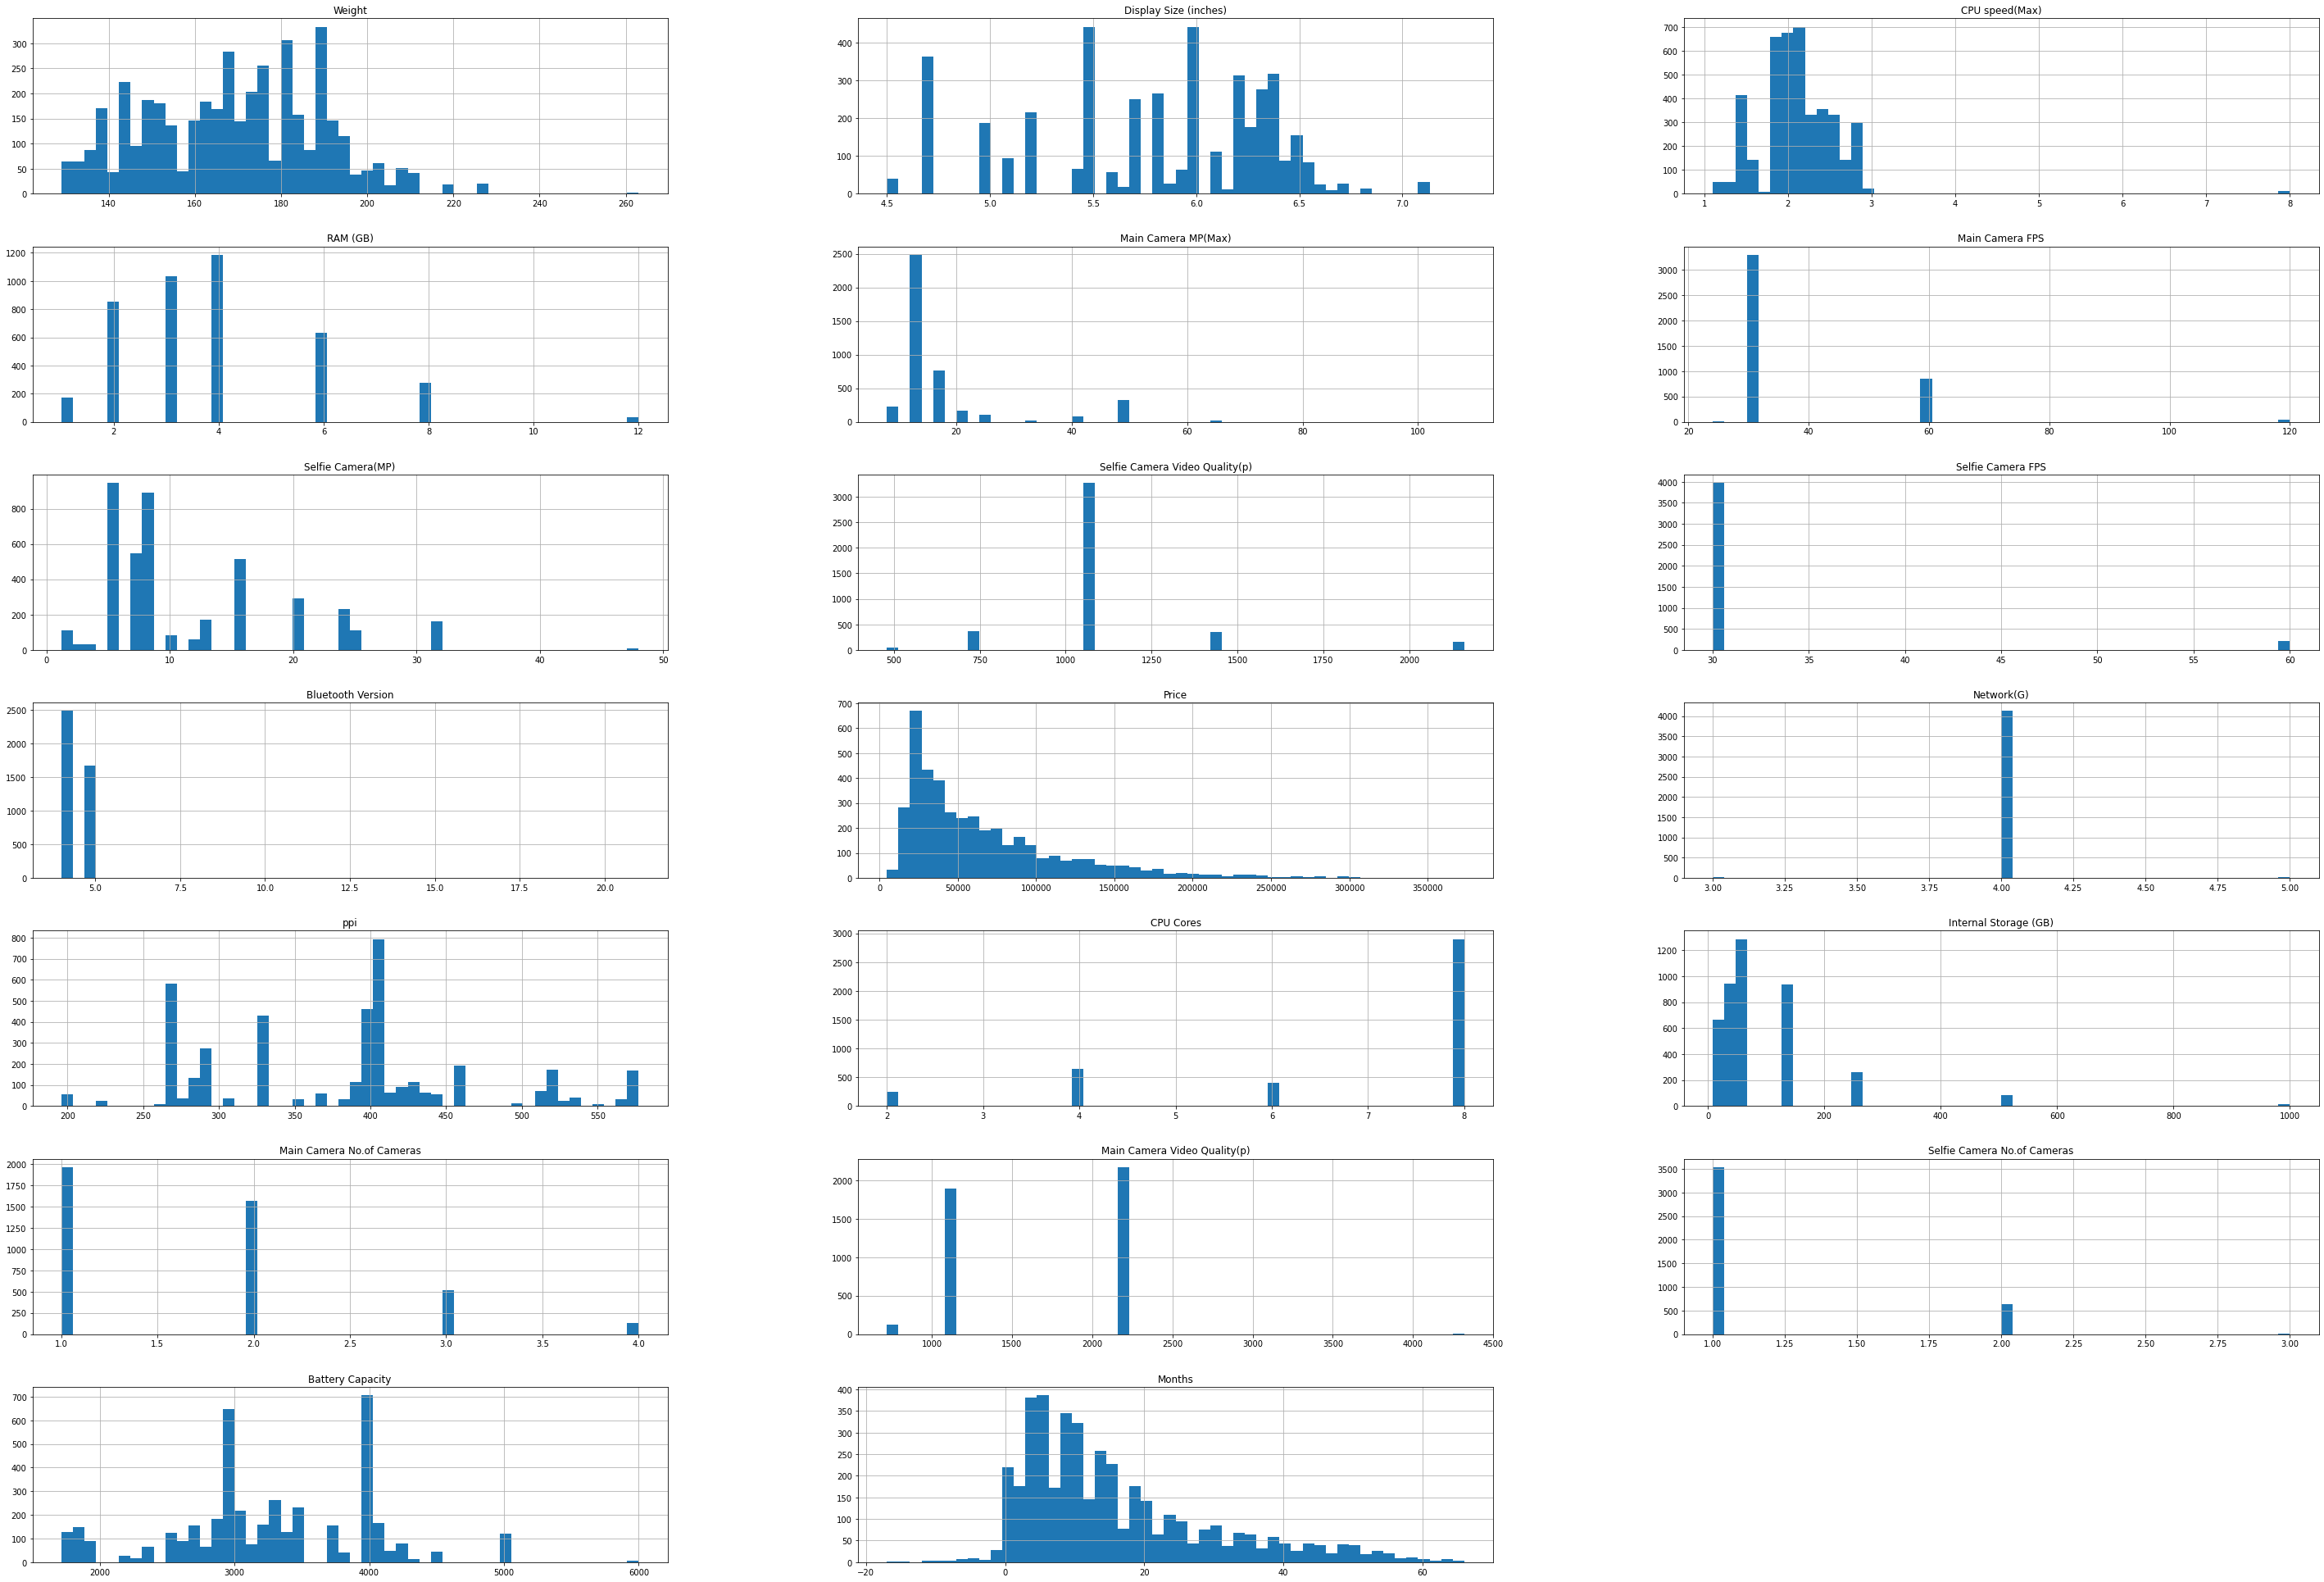

In [65]:
#plot histograms to numerical features
data[numerical_cols].hist(bins=50,figsize=(50,50), layout=(10,3), rwidth=5)
plt.show()

Box Plot of numerical data fields

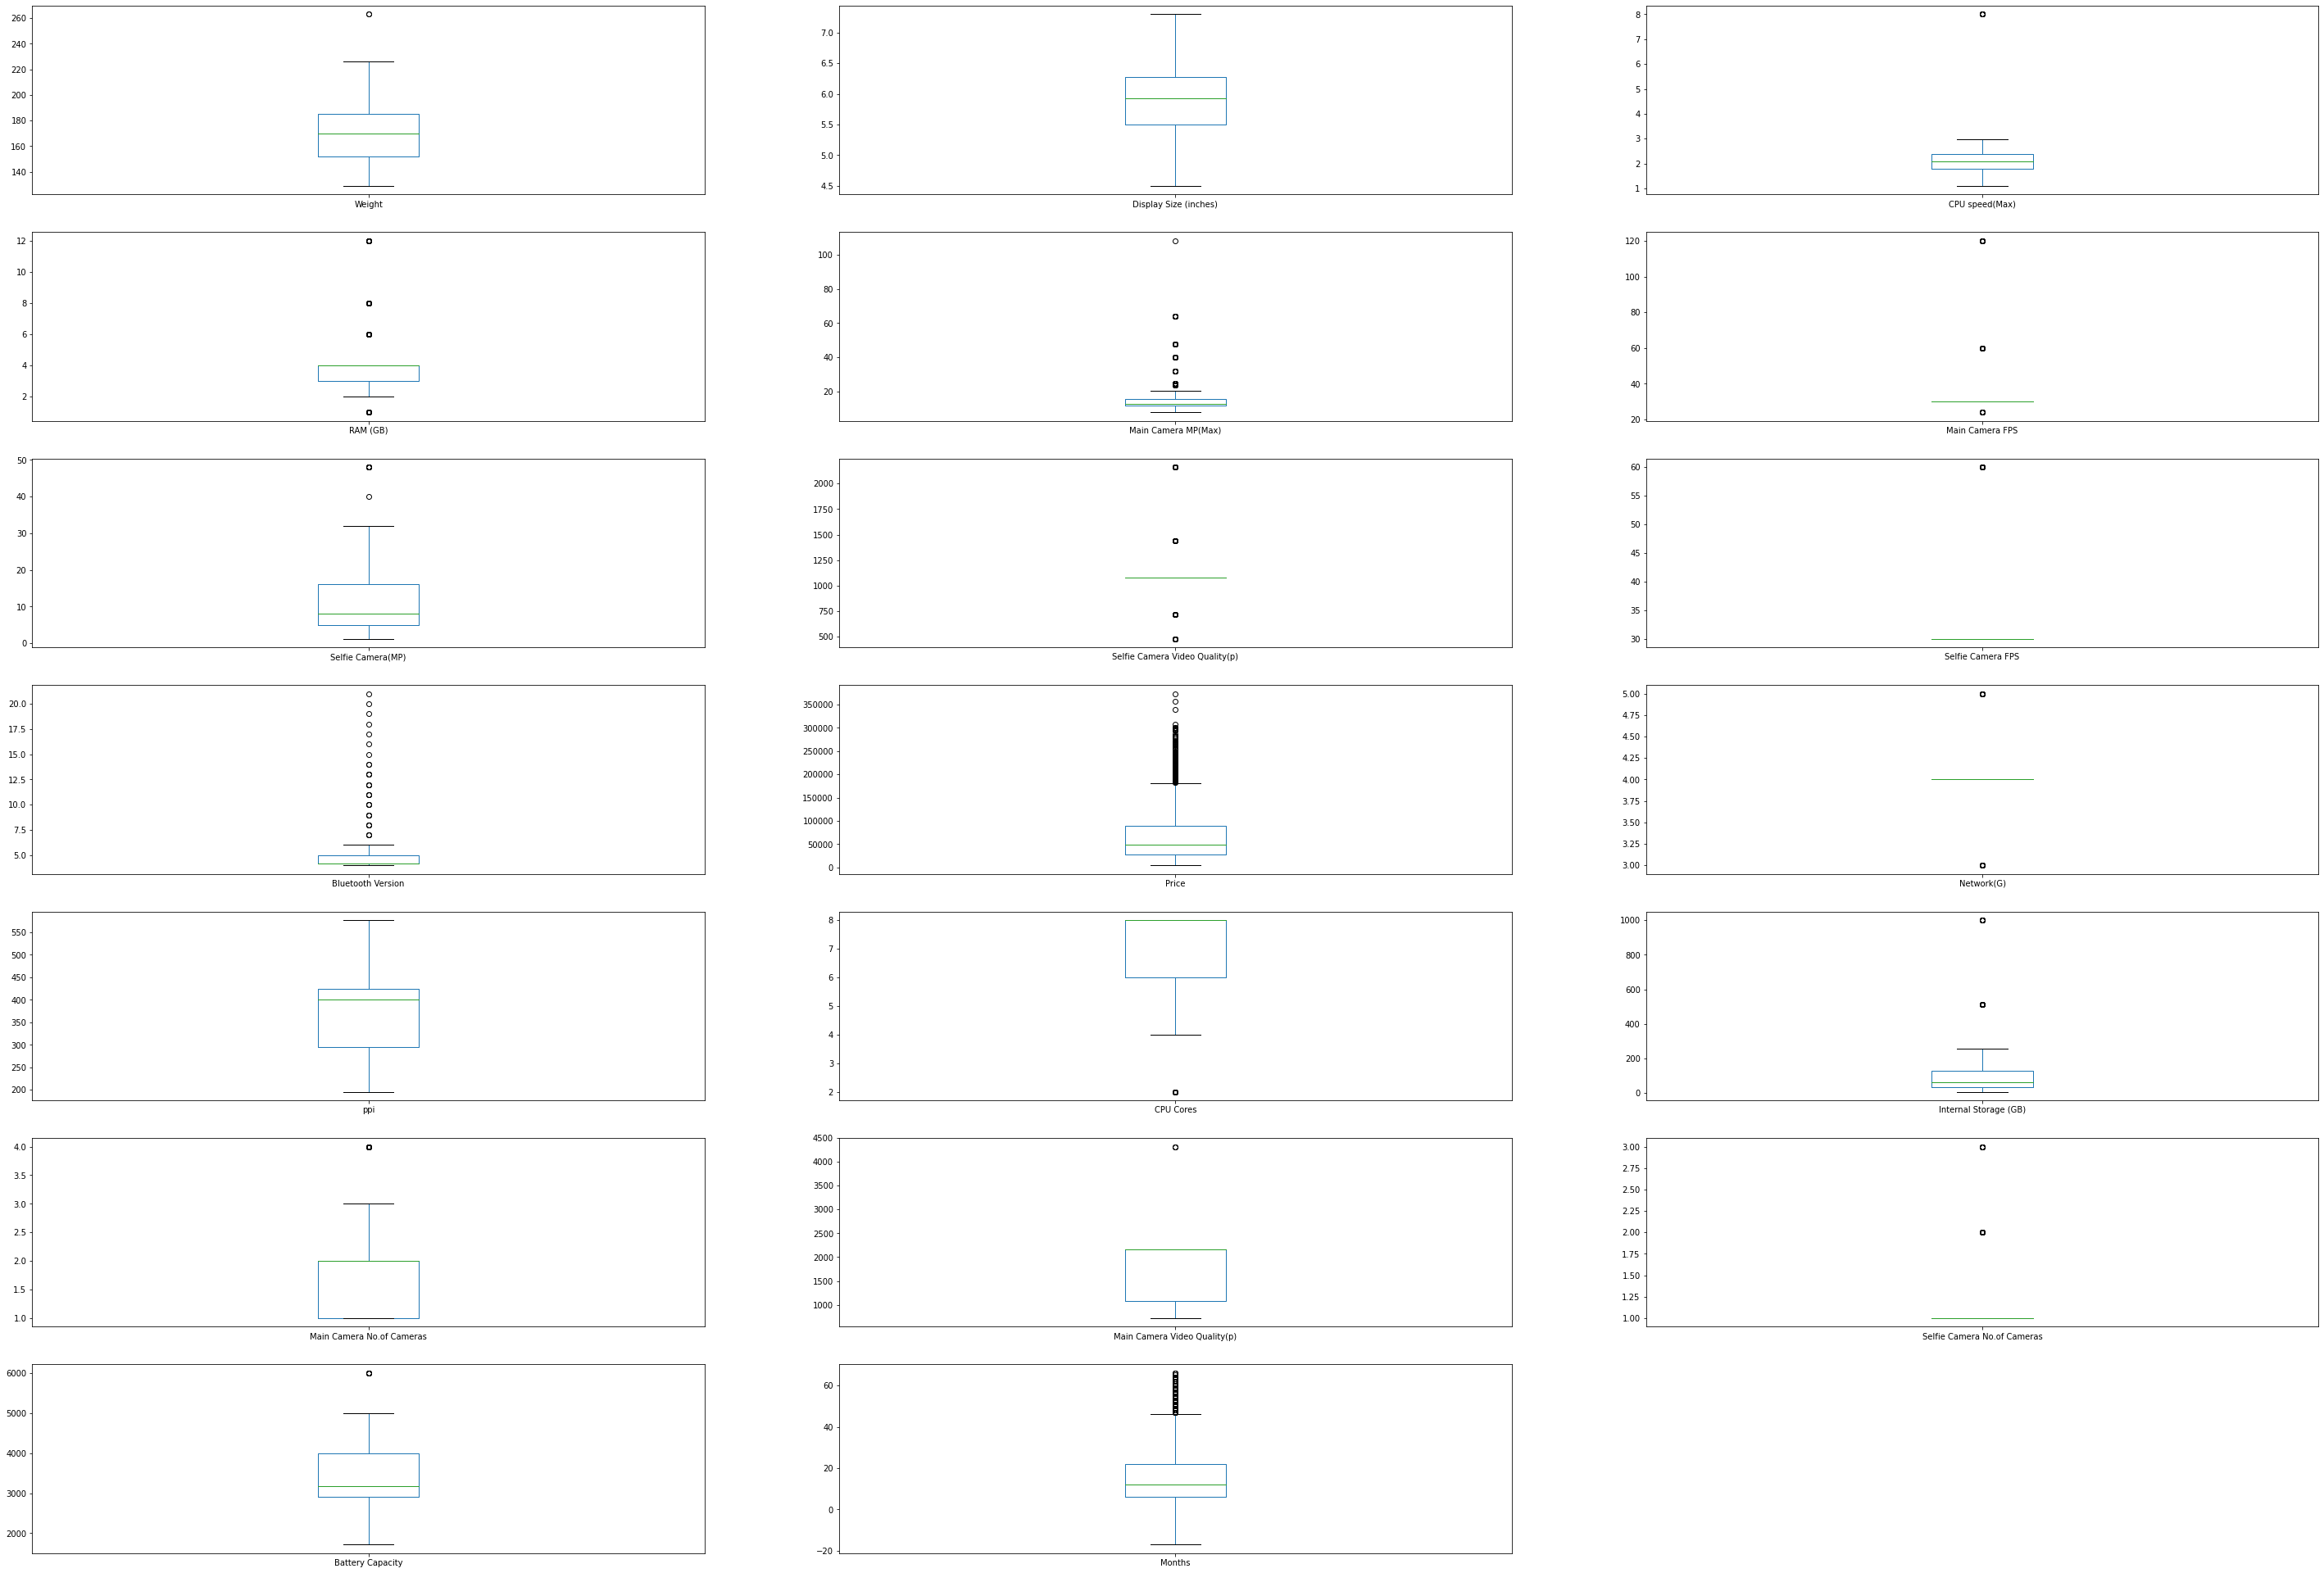

In [66]:
data[numerical_cols].plot(kind='box',subplots = True,figsize=(50,50),layout = (10,3),sharex = False, sharey = False)
plt.show()

**Removing Outliers**

By observing the box plots, we can identify that there are several considerable outliers in some columns of the dataset.

By analysing the box plots, we have decided to clean the outliers given below


1.   CPU speed(Max)
2.   Bluetooth Version
3.   Internal Storage (GB)

Note: There are other columns with outliers but considering the nature of the column, it is not fair to categorize them as outliers. 
Eg. Box plot detects that the RAM columns has outliers upto 12GB but in reality, the dataset contains phones with a RAM of upto 12 GB.



**CPU speed(Max)**

In [67]:
#Replace outliers with median
resolveOutliers('CPU speed(Max)')


Upperbound 3.2750000000000004
Lowerbound 0.9149999999999999
Median  CPU speed(Max) : 2.1


**Bluetooth Version**

In [68]:
#Replace outliers with median
resolveOutliers('Bluetooth Version')

Upperbound 6.199999999999999
Lowerbound 3.0000000000000004
Median  Bluetooth Version : 4.2


**Internal Storage (GB)**

In [69]:
#Replace outliers with median
resolveOutliers('Internal Storage (GB)')

Upperbound 272.0
Lowerbound 0
Median  Internal Storage (GB) : 64.0


Box plots of Outlier - Corrected columns

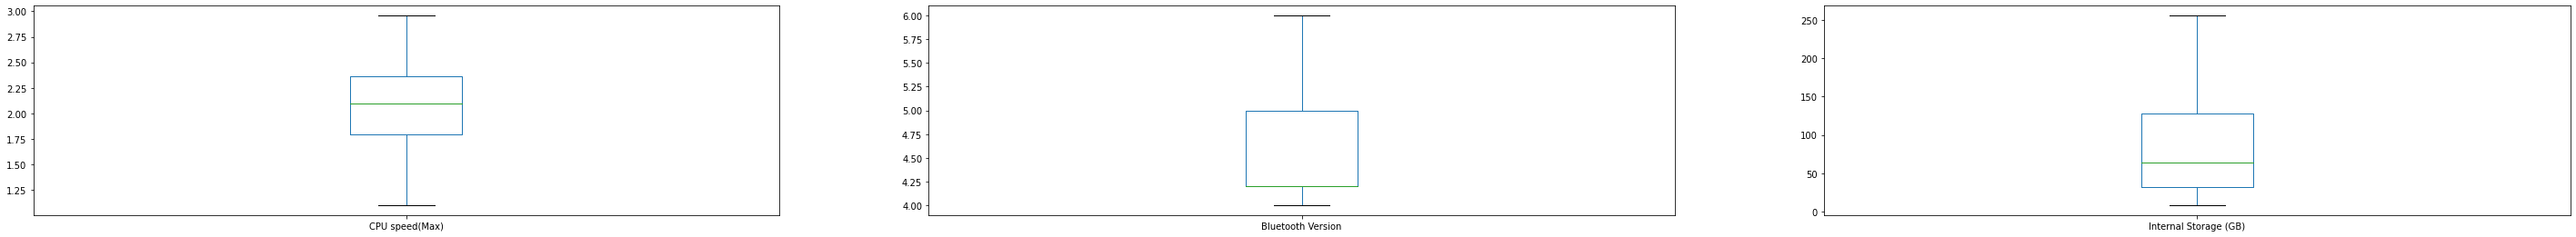

In [70]:
data[["CPU speed(Max)", "Bluetooth Version",'Internal Storage (GB)']].plot(kind='box',subplots = True,figsize=(50,50),layout = (10,3),sharex = False, sharey = False)
plt.show()

Scatter Plot of numerical data fields

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b0f14d910>,
      dtype=object)

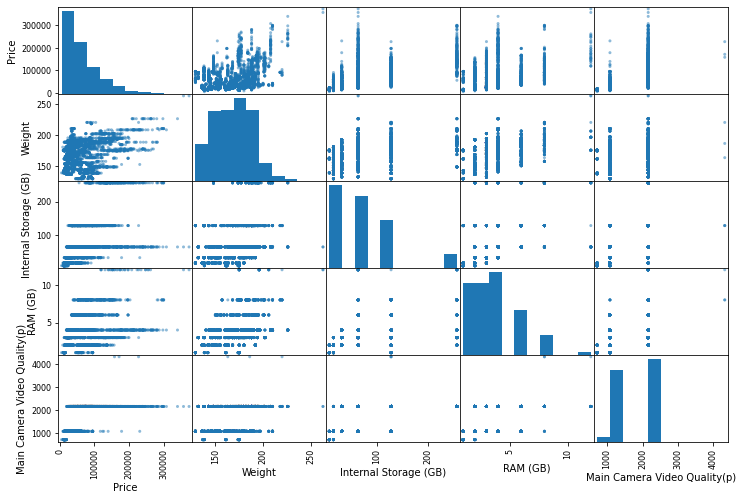

In [71]:
from pandas.plotting import scatter_matrix
attributes = ["Price", "Weight", "Internal Storage (GB)", "RAM (GB)","Main Camera Video Quality(p)"]
scatter_matrix(data[attributes], figsize=(12, 8))

**One Hot Encoding of Categorical Data**

In [72]:
#Get a list of columns with categorical data
nominal_cols = data.columns[data.dtypes==object].tolist()
nominal_cols


['Brand',
 'Build Back',
 'Build Frame',
 'SIM',
 'Display type',
 'Protection',
 'OS']

In [73]:
#encoding the categorical features
from sklearn.preprocessing import OneHotEncoder
hot_encoder = OneHotEncoder()

phone_hot = hot_encoder.fit_transform(data[nominal_cols]).toarray()
phone_hot

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [74]:
#Generating labels for columns
phoneLabels = hot_encoder.get_feature_names(nominal_cols)
phoneLabels

array(['Brand_Apple', 'Brand_BlackBerry', 'Brand_Google', 'Brand_HTC',
       'Brand_Huawei', 'Brand_Nokia', 'Brand_Oneplus', 'Brand_Oppo',
       'Brand_Samsung', 'Brand_Sony', 'Brand_Vivo', 'Brand_Xiaomi',
       'Build Back_Aluminium', 'Build Back_Cerramic', 'Build Back_Glass',
       'Build Back_Leather', 'Build Back_Leather/glass',
       'Build Back_Plastic', 'Build Frame_Aluminium',
       'Build Frame_Plastic', 'Build Frame_Stainless steel', 'SIM_Dual',
       'SIM_Single', 'Display type_AMOLED', 'Display type_IPS - LCD',
       'Display type_LCD', 'Display type_OLED', 'Display type_PLS TFT',
       'Protection_Asahi Dragontrail Glass',
       'Protection_Corning Gorilla Glass',
       'Protection_Ion-strengthened glass', 'Protection_No protection',
       'Protection_Scratch-resistant glass', 'OS_Android', 'OS_iOS'],
      dtype=object)

In [75]:
#converting the encoded array into a dataframe
features = pd.DataFrame(phone_hot, columns=phoneLabels)
features.head(5)

,Brand_Apple,Brand_BlackBerry,Brand_Google,Brand_HTC,Brand_Huawei,Brand_Nokia,Brand_Oneplus,Brand_Oppo,Brand_Samsung,Brand_Sony,Brand_Vivo,Brand_Xiaomi,Build Back_Aluminium,Build Back_Cerramic,Build Back_Glass,Build Back_Leather,Build Back_Leather/glass,Build Back_Plastic,Build Frame_Aluminium,Build Frame_Plastic,Build Frame_Stainless steel,SIM_Dual,SIM_Single,Display type_AMOLED,Display type_IPS - LCD,Display type_LCD,Display type_OLED,Display type_PLS TFT,Protection_Asahi Dragontrail Glass,Protection_Corning Gorilla Glass,Protection_Ion-strengthened glass,Protection_No protection,Protection_Scratch-resistant glass,OS_Android,OS_iOS
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [76]:
#Drop the unencoded categorigal features
data = data.drop(columns=nominal_cols)

In [77]:
#merge the original dataset with the encoded feature dataset
data = pd.concat([data.reset_index(drop=True),features.reset_index(drop=True)], axis=1)
data.head(5)

,Network(G),Weight,Display Size (inches),ppi,CPU Cores,CPU speed(Max),SD Card Slot,Internal Storage (GB),RAM (GB),Main Camera No.of Cameras,Main Camera MP(Max),Main Camera Video Quality(p),Main Camera FPS,Selfie Camera No.of Cameras,Selfie Camera(MP),Selfie Camera Video Quality(p),Selfie Camera FPS,Stereo Speakers,3.5mm jack,Bluetooth Version,NFC,Radio,Fingerprint,Face ID,Battery Capacity,Fast Charging,Wireless Charging,Reverse wireless charging,Price,Months,Brand_Apple,Brand_BlackBerry,Brand_Google,Brand_HTC,Brand_Huawei,Brand_Nokia,Brand_Oneplus,Brand_Oppo,Brand_Samsung,Brand_Sony,Brand_Vivo,Brand_Xiaomi,Build Back_Aluminium,Build Back_Cerramic,Build Back_Glass,Build Back_Leather,Build Back_Leather/glass,Build Back_Plastic,Build Frame_Aluminium,Build Frame_Plastic,Build Frame_Stainless steel,SIM_Dual,SIM_Single,Display type_AMOLED,Display type_IPS - LCD,Display type_LCD,Display type_OLED,Display type_PLS TFT,Protection_Asahi Dragontrail Glass,Protection_Corning Gorilla Glass,Protection_Ion-strengthened glass,Protection_No protection,Protection_Scratch-resistant glass,OS_Android,OS_iOS
0,4,129.0,4.7,326,2,1.4,False,16.0,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,67015.90797,30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,4,129.0,4.7,326,2,1.4,False,16.0,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,66537.91492,31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,4,129.0,4.7,326,2,1.4,False,16.0,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,66164.64992,32,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4,129.0,4.7,326,2,1.4,False,16.0,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,64271.06467,33,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,4,129.0,4.7,326,2,1.4,False,16.0,1.0,1,8.0,1080,60.0,1,1.2,720.0,30.0,False,True,4.0,True,False,True,False,1810,False,False,False,61048.85175,34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4192 entries, 0 to 4191
Data columns (total 65 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Network(G)                          4192 non-null   int64  
 1   Weight                              4192 non-null   float64
 2   Display Size (inches)               4192 non-null   float64
 3   ppi                                 4192 non-null   int64  
 4   CPU Cores                           4192 non-null   int64  
 5   CPU speed(Max)                      4192 non-null   float64
 6   SD Card Slot                        4192 non-null   bool   
 7   Internal Storage (GB)               4192 non-null   float64
 8   RAM (GB)                            4192 non-null   float64
 9   Main Camera No.of Cameras           4192 non-null   int64  
 10  Main Camera MP(Max)                 4192 non-null   float64
 11  Main Camera Video Quality(p)        4192 no

After cleaning data, we have 4192 entries in out dataset.

# **Feature Selection**

Now we obtain Pearson Correlation Coefficient

In [79]:
corr_matrix = data.corr()
pd.set_option('display.max_rows', None)
corr_matrix["Price"].sort_values(ascending=False)

Price                                 1.000000
Wireless Charging                     0.648006
Main Camera Video Quality(p)          0.639835
Display type_OLED                     0.630425
CPU speed(Max)                        0.621356
Face ID                               0.591886
Build Frame_Stainless steel           0.569470
OS_iOS                                0.560880
Brand_Apple                           0.560880
Internal Storage (GB)                 0.560181
Selfie Camera FPS                     0.548538
Build Back_Glass                      0.503823
ppi                                   0.485838
NFC                                   0.469419
Selfie Camera Video Quality(p)        0.468363
Fast Charging                         0.449193
Selfie Camera No.of Cameras           0.447819
Bluetooth Version                     0.438714
Protection_Scratch-resistant glass    0.429598
SIM_Single                            0.408822
Main Camera FPS                       0.408125
Weight       

HeatMap of Pearson correlation coefficient

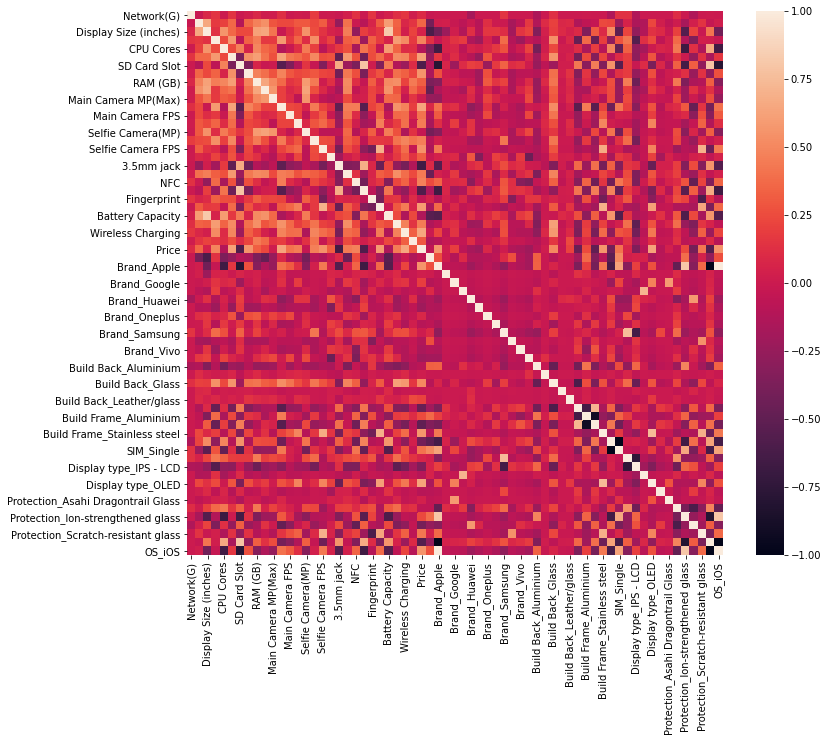

In [80]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix)

Next, we obtain Spearman correlation coefficient

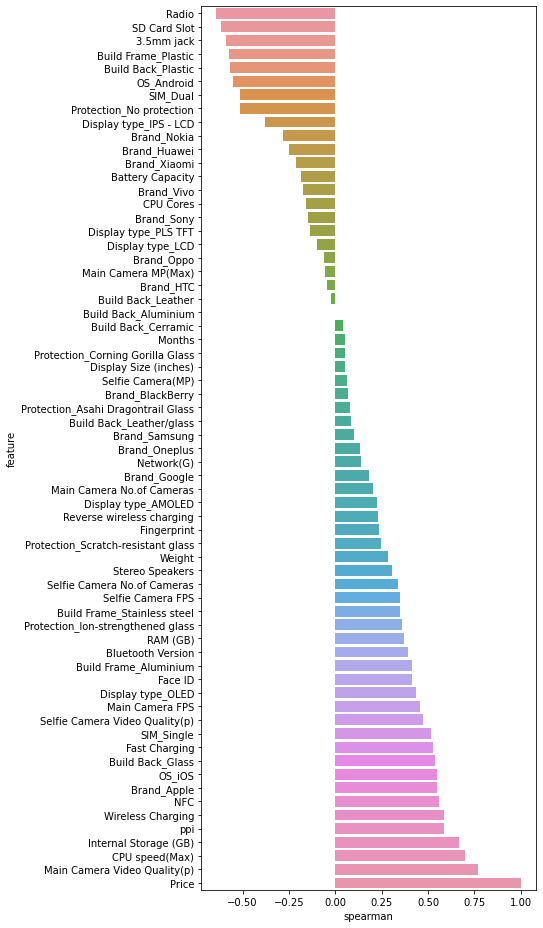

In [81]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['Price'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
features = data.columns
spearman(data, features)

By considering both correlation coefficients, the features with very low correlation is removed from the dataset.

In [82]:
#drop features with less correlation taking both spearman and pearson correlation coefficients into consideration.
data = (data.drop(['Main Camera MP(Max)', 'Selfie Camera(MP)', 'Network(G)', 'Display Size (inches)', 'CPU Cores', 'Fingerprint'], 1))


In [83]:
predict = "Price" #target

X = (data.drop([predict], 1)) # Features
y = (data[predict]) # Labels

Perform Feature Scaling to get better results

In [84]:
#feature scaling
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
pickle.dump(min_max_scaler, open("scaler.pkl", 'wb'))
X = pd.DataFrame(X, columns=data.drop([predict],1).columns)

Create train and test datasets

In [85]:
#split data to train and test
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.2, random_state = 1)

# **Model Building**

**Linear Regression Model**

In [86]:
#linear regression model
model_Linear = linear_model.LinearRegression()
model_Linear.fit(X_train, y_train)
acc = model_Linear.score(X_test, y_test) # acc stands for accuracy 
print("accuracy = ",acc)

accuracy =  0.9205982977980032


In [87]:
# Gets a list of all predictions
y_train_predLin = model_Linear.predict(X_train) #prediction for training data
y_test_predLin = model_Linear.predict(X_test) #prediction for testing data

#Print predicted price and real price for 10 rows
print_Predictions(y_test_predLin)

Predicted price     Real price
76384.0      76683.21392
Predicted price     Real price
4928.0      13038.56398
Predicted price     Real price
27344.0      23905.11627906973
Predicted price     Real price
56256.0      58528.65266666666
Predicted price     Real price
26576.0      44120.0
Predicted price     Real price
11280.0      29380.3116147308
Predicted price     Real price
40640.0      36820.937333333335
Predicted price     Real price
12208.0      32819.7417503586
Predicted price     Real price
57056.0      62313.945
Predicted price     Real price
17168.0      22359.7860962566


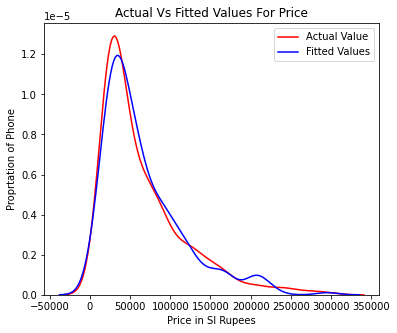

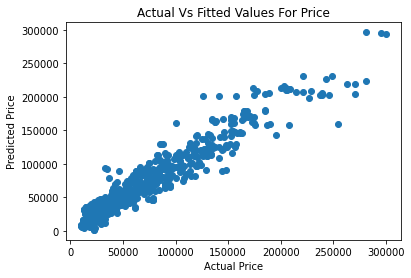

In [88]:
#Graphical representation of the actual value and the predicated value
graphical_Representation(y_test_predLin)

In [89]:
#evaluate linear model
print_evaluate(y_train, y_train_predLin, train=True)
print_evaluate(y_test, y_test_predLin, train=False)

========Training Result=======
MAE:  10620.381713699786
MSE:  264883321.96580204
RMSE:  16275.236464205429
R2 Square:  0.9008992288763086
=========Testing Result=======
MAE:  10091.389505179124
MSE:  218471979.43649986
RMSE:  14780.797659006765
R2 Square:  0.9205982977980032


 **Neural Network**

In [90]:
model_NeuralNet = Sequential()
#input layer
model_NeuralNet.add(Dense(X_train.shape[1],activation='relu'))

# hidden layers
model_NeuralNet.add(Dense(128,activation='relu'))
model_NeuralNet.add(Dense(64,activation='relu'))
model_NeuralNet.add(Dense(32,activation='relu'))
model_NeuralNet.add(Dropout(0.2))

#output layer
model_NeuralNet.add(Dense(1))

model_NeuralNet.compile(optimizer='adam', loss='mse')

In [91]:
from keras import callbacks 
#use early stopping to prevent overfitting
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 20,  
                                        restore_best_weights = True) 
  
r = model_NeuralNet.fit(X_train, y_train.values,
              validation_split=0.25,
              batch_size=128,
              epochs=5000,  
                    callbacks =[earlystopping]) 

Epoch 1/5000
20/20 [==============================] - 1s 44ms/step - loss: 7170228224.0000 - val_loss: 7389816320.0000
Epoch 2/5000
20/20 [==============================] - 0s 5ms/step - loss: 6918714977.5238 - val_loss: 7381920256.0000
Epoch 3/5000
20/20 [==============================] - 0s 6ms/step - loss: 6829301418.6667 - val_loss: 7326242304.0000
Epoch 4/5000
20/20 [==============================] - 0s 5ms/step - loss: 7344793136.7619 - val_loss: 7073129472.0000
Epoch 5/5000
20/20 [==============================] - 0s 6ms/step - loss: 6623436483.0476 - val_loss: 6259812352.0000
Epoch 6/5000
20/20 [==============================] - 0s 6ms/step - loss: 5324831622.0952 - val_loss: 4480982528.0000
Epoch 7/5000
20/20 [==============================] - 0s 7ms/step - loss: 3913588382.4762 - val_loss: 2518570240.0000
Epoch 8/5000
20/20 [==============================] - 0s 6ms/step - loss: 2019161100.1905 - val_loss: 1935333888.0000
Epoch 9/5000
20/20 [==============================] - 0

In [92]:
#Get a list of predictions
y_train_predNN = model_NeuralNet.predict(X_train) #prediction for training data
y_test_predNN = model_NeuralNet.predict(X_test) #prediction for testing data

#Print predicted price and real price for 10 rows
print_Predictions(y_test_predNN)

Predicted price     Real price
[72467.336]      76683.21392
Predicted price     Real price
[13595.753]      13038.56398
Predicted price     Real price
[27553.543]      23905.11627906973
Predicted price     Real price
[52440.79]      58528.65266666666
Predicted price     Real price
[35739.867]      44120.0
Predicted price     Real price
[25921.682]      29380.3116147308
Predicted price     Real price
[35909.055]      36820.937333333335
Predicted price     Real price
[25728.627]      32819.7417503586
Predicted price     Real price
[52219.492]      62313.945
Predicted price     Real price
[24698.994]      22359.7860962566


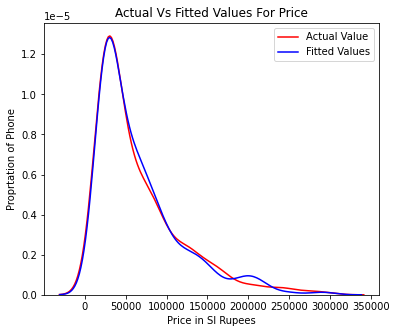

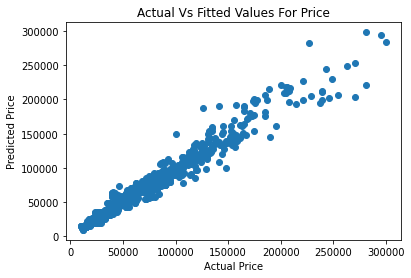

In [93]:
#Graphical representation of the actual value and the predicated value
graphical_Representation(y_test_predNN)

In [94]:
#evaluate the model
print_evaluate(y_train, y_train_predNN, train=True)
print_evaluate(y_test, y_test_predNN, train=False)


========Training Result=======
MAE:  6741.6302313295355
MSE:  127540530.52334608
RMSE:  11293.384369769148
R2 Square:  0.9522832738936273
=========Testing Result=======
MAE:  6649.746586850894
MSE:  113279328.57525522
RMSE:  10643.27621436441
R2 Square:  0.9588296332720834


**Decision Tree**

In [95]:
#decision tree
modelDecisionTree = DecisionTreeRegressor()
modelDecisionTree.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [96]:
y_train_predDT = modelDecisionTree.predict(X_train)
y_test_predDT = modelDecisionTree.predict(X_test)

#Print predicted price and real price for 10 rows
print_Predictions(y_test_predDT)

Predicted price     Real price
73186.36195      76683.21392
Predicted price     Real price
13280.59975      13038.56398
Predicted price     Real price
24898.822674418552      23905.11627906973
Predicted price     Real price
58186.92966666666      58528.65266666666
Predicted price     Real price
42980.469      44120.0
Predicted price     Real price
32819.7417503586      29380.3116147308
Predicted price     Real price
37202.746333333336      36820.937333333335
Predicted price     Real price
31138.371134374825      32819.7417503586
Predicted price     Real price
60012.529      62313.945
Predicted price     Real price
22507.313932526347      22359.7860962566


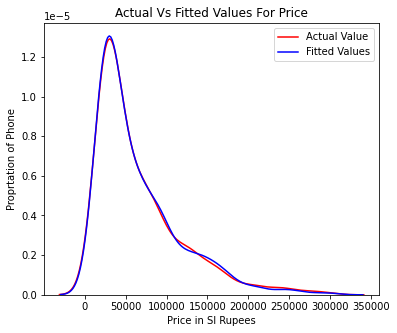

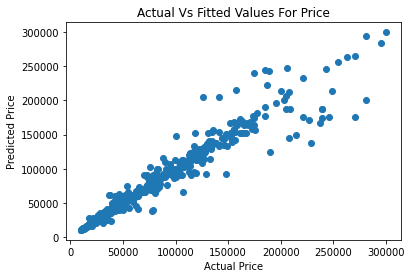

In [97]:
#Graphical representation of the actual value and the predicated value
graphical_Representation(y_test_predDT)

In [98]:
#evaluate the model
print_evaluate(y_train, y_train_predDT, train=True)
print_evaluate(y_test, y_test_predDT, train=False)

========Training Result=======
MAE:  520.622063435876
MSE:  13449292.878006382
RMSE:  3667.3277571013996
R2 Square:  0.9949682173819502
=========Testing Result=======
MAE:  4563.774995266279
MSE:  149254268.33483636
RMSE:  12216.96641293723
R2 Square:  0.9457548606587136


In [99]:
crossValidate(modelDecisionTree)

Average accuracy of 10 folds :  0.9460194070311706


**Random Forest Regression**

In [100]:
#random forest
modelRandomForest = RandomForestRegressor(random_state=1)

In [101]:
modelRandomForest.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [102]:
y_train_predRF = modelRandomForest.predict(X_train)
y_test_predRF = modelRandomForest.predict(X_test)

#Print predicted price and real price for 10 rows
print_Predictions(y_test_predRF)

Predicted price     Real price
72607.5915195999      76683.21392
Predicted price     Real price
13510.079234833347      13038.56398
Predicted price     Real price
24813.569633176285      23905.11627906973
Predicted price     Real price
57957.70806484077      58528.65266666666
Predicted price     Real price
43418.995143585365      44120.0
Predicted price     Real price
32058.9364189147      29380.3116147308
Predicted price     Real price
37082.57189589194      36820.937333333335
Predicted price     Real price
31324.637079403317      32819.7417503586
Predicted price     Real price
61505.96443157253      62313.945
Predicted price     Real price
22435.384830168394      22359.7860962566


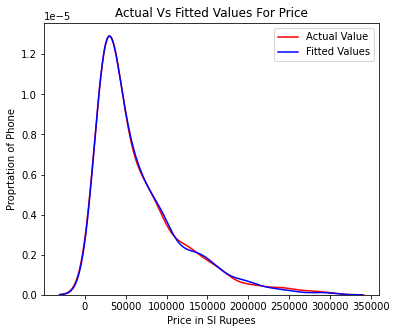

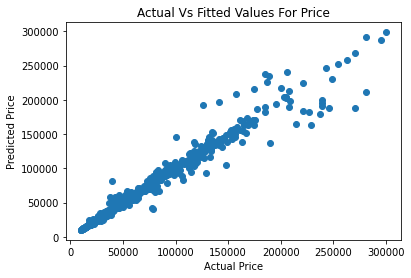

In [103]:
#Graphical representation of the actual value and the predicated value
graphical_Representation(y_test_predRF)

In [104]:
#evaluate the model
print_evaluate(y_train, y_train_predRF, train=True)
print_evaluate(y_test, y_test_predRF, train=False)

========Training Result=======
MAE:  1627.5848009213903
MSE:  22164864.300007604
RMSE:  4707.957550786498
R2 Square:  0.9917074615053857
=========Testing Result=======
MAE:  3801.053647326924
MSE:  97594556.55627392
RMSE:  9878.995726098576
R2 Square:  0.9645301244754385


In [105]:
crossValidate(modelRandomForest);

Average accuracy of 10 folds :  0.9649731327726958


# **Model Comparison**

In [106]:
print("----------Linear Regression----------\n")
print_evaluate(y_test, y_test_predLin, train=False)
print("\n----------Neural Network----------\n")
print_evaluate(y_test, y_test_predNN, train=False)
print("\n----------Decision Tree----------\n")
print_evaluate(y_test, y_test_predDT, train=False)
print("\n----------Random Forest----------\n")
print_evaluate(y_test, y_test_predRF, train=False)


----------Linear Regression----------

=========Testing Result=======
MAE:  10091.389505179124
MSE:  218471979.43649986
RMSE:  14780.797659006765
R2 Square:  0.9205982977980032

----------Neural Network----------

=========Testing Result=======
MAE:  6649.746586850894
MSE:  113279328.57525522
RMSE:  10643.27621436441
R2 Square:  0.9588296332720834

----------Decision Tree----------

=========Testing Result=======
MAE:  4563.774995266279
MSE:  149254268.33483636
RMSE:  12216.96641293723
R2 Square:  0.9457548606587136

----------Random Forest----------

=========Testing Result=======
MAE:  3801.053647326924
MSE:  97594556.55627392
RMSE:  9878.995726098576
R2 Square:  0.9645301244754385


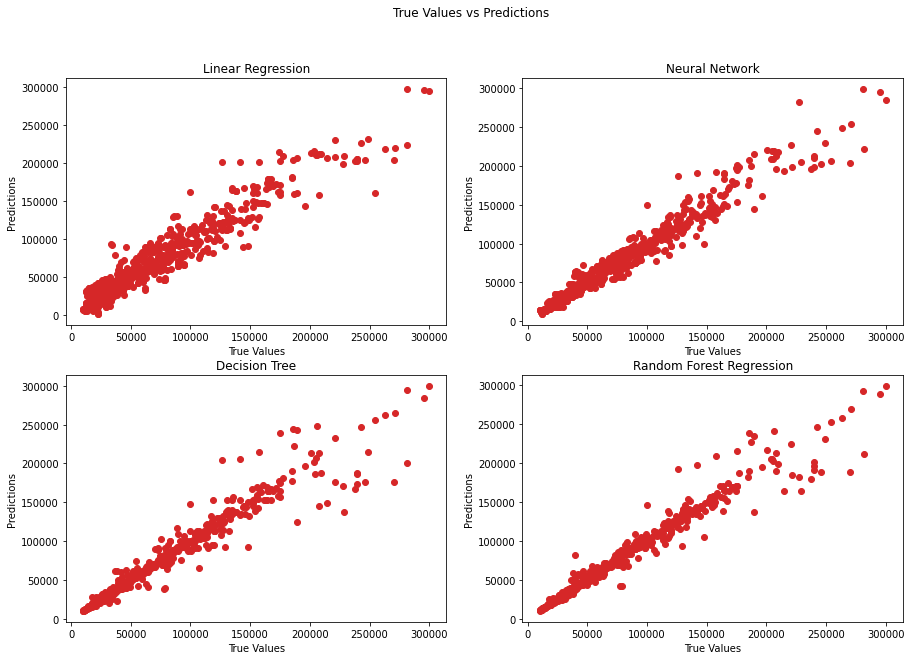

In [107]:
fig, ((fig1, fig2),(fig3, fig4)) = plt.subplots(2,2, figsize=(15, 10))
fig.suptitle('True Values vs Predictions')

fig1.scatter(y_test, y_test_predLin, c="#d62728")
fig1.set_title('Linear Regression')

fig2.scatter(y_test, y_test_predNN, c="#d62728")
fig2.set_title('Neural Network')

fig3.scatter(y_test, y_test_predDT, c="#d62728")
fig3.set_title('Decision Tree')

fig4.scatter(y_test, y_test_predRF, c="#d62728")
fig4.set_title('Random Forest Regression')

for figures in fig.get_axes():
    figures.set(xlabel='True Values', ylabel='Predictions')